In [55]:
import pandas as pd
import os
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.normalizers import NFD, StripAccents, Lowercase
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import re
import requests
import random
from functools import partial
import math
import matplotlib.pyplot as plt
import numpy as np

# Masked Language Modeling and Transformer related Code

In [56]:
# Directories
cwd= os.getcwd()
data_dir= cwd + "/data/"
artifacts_dir= cwd + "/artifacts/"

In [57]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

if response.status_code == 200:
    text = response.text
    print(f"Length of text: {len(text)}")
    print("First 500 Chars")
    print("\n" + "=" * 50 + "\n")

    corpus_path = os.path.join(data_dir, "corpus.txt")
    with open(corpus_path, 'w', encoding='utf-8') as f:
        f.write(text)

    print(f"Successfully saved corpus to: {corpus_path}")
    print(f"File size: {os.path.getsize(corpus_path)} bytes")

else:
    print(f"Failed to download text. Status code: {response.status_code}")


Length of text: 1115394
First 500 Chars


Successfully saved corpus to: /content/data/corpus.txt
File size: 1115394 bytes


In [58]:
with open(corpus_path, 'r', encoding= 'utf-8') as f:
    text= f.read()

texts= re.split(r'(?<=[.!?]) +', text)
split_idx= int(0.9 * len(texts))
train_sentences= texts[:split_idx]
val_sentences= texts[split_idx:]

In [59]:
def train_bpe_tokenizer(texts, vocab_size= 30000, min_frequency= 2):
    # Initialize a tokenizer
    tokenizer= Tokenizer(BPE(unk_token= '[UNK]'))
    # Add normalizers
    tokenizer.normalizer= normalizers.Sequence([NFD(), StripAccents(), Lowercase()])
    # Use whitespace pre-tokenization
    tokenizer.pre_tokenizer= Whitespace()
    special_tokens= ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    # Initialize trainer
    trainer= BpeTrainer(
        vocab_size= vocab_size,
        special_tokens= special_tokens,
        min_frequency= min_frequency,
        show_progress= True
    )

    # Train the tokenizer
    tokenizer.train_from_iterator(texts, trainer=trainer)

    cls_id= tokenizer.token_to_id("[CLS]")
    sep_id= tokenizer.token_to_id("[SEP]")

    if cls_id is not None and sep_id is not None:

        tokenizer.post_processor = TemplateProcessing(
            single="[CLS] $A [SEP]",
            pair="[CLS] $A [SEP] $B:1 [SEP]:1",
            special_tokens=[
                ("[CLS]", cls_id),
                ("[SEP]", sep_id),
            ],
        )
    else:
        print("Warning: [CLS] or [SEP] tokens not found in vocabulary")

    return tokenizer

In [60]:
tokenizer= train_bpe_tokenizer(train_sentences, vocab_size= 10000, min_frequency= 2)
tokenizer.save(artifacts_dir+"mlm_tokenizer.json")

In [61]:
mlm_tokenizer= Tokenizer.from_file(artifacts_dir + "mlm_tokenizer.json")
encoded= mlm_tokenizer.encode("To be, or not to be: That is the question.")
print(encoded.tokens)
print(encoded.ids)

['[CLS]', 'to', 'be', ',', 'or', 'not', 'to', 'be', ':', 'that', 'is', 'the', 'question', '.', '[SEP]']
[2, 57, 69, 9, 48, 91, 57, 69, 13, 81, 51, 47, 2356, 11, 3]


In [62]:
mask_token_id= mlm_tokenizer.token_to_id("[MASK]")
mask_token_id

4

In [63]:
def tokenize_dataset(sentences, tokenizer):
    all_token_ids= []
    for sentence in sentences:
        encoding= tokenizer.encode(sentence)
        all_token_ids.extend(encoding.ids)
    return all_token_ids

train_token_ids= tokenize_dataset(train_sentences, tokenizer)
val_token_ids= tokenize_dataset(val_sentences, tokenizer)

print(f"Training tokens: {len(train_token_ids)}")
print(f"Val token ids: {len(val_token_ids)}")

Training tokens: 253249
Val token ids: 20991


In [64]:
class MLMShakespeareDataset(Dataset):
    def __init__(self,
                 sentences,
                 tokenizer,
                 max_length= 512):

        self.tokenizer= tokenizer
        self.max_length= max_length
        self.mask_token_id= tokenizer.token_to_id("[MASK]")
        self.pad_token_id= tokenizer.token_to_id("[PAD]")

        self.sentences= sentences
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # Get the token IDs for the sentence
        return self.sentences[idx]


In [65]:
def custom_collate_fn(batch, tokenizer, max_length, mask_probability= 0.15):
    mask_token_id= tokenizer.token_to_id("[MASK]")
    pad_token_id= tokenizer.token_to_id("[PAD]")

    special_token_ids= [tokenizer.token_to_id("[UNK]"),
                        pad_token_id,
                        tokenizer.token_to_id("[CLS]"),
                        tokenizer.token_to_id("[SEP]"),
                        mask_token_id]

    batch_input_ids= []
    batch_labels= []
    batch_attention_mask= []

    for text in batch:
        # 1. Tokenize text
        encoding= tokenizer.encode(text)
        token_ids= encoding.ids[:max_length] # Truncating

        # 2. Init arrays for this sample
        input_ids= token_ids.copy()
        labels= [-100] * len(token_ids) # Using -100 to fill because it's ignored by PyTorch's CE Loss

        # 3. Apply Masking (80/10/10 rule)
        for i, token_id in enumerate(token_ids):
            if token_id in special_token_ids:
                continue
            if random.random() < mask_probability:
                labels[i]= token_id
                rand= random.random()
                if rand < 0.8:
                    # 80%: mask token with mask_id
                    input_ids[i]= mask_token_id
                elif rand < 0.9:
                    # 10%: Choose random token to hide current token
                    all_vocab_ids= list(tokenizer.get_vocab().values())
                    regular_ids= [id_ for id_ in all_vocab_ids if id_ not in special_token_ids]
                    input_ids[i]= random.choice(regular_ids)
                # else: 10% leave unchanged input_ids[i] is already token_id (original token)

        batch_input_ids.append(input_ids)
        batch_labels.append(labels)
        # Actual length of this seq before padding
        batch_attention_mask.append([1] * len(token_ids))

    # 4. Pad the batch to the longest seq in this batch (or max_len)
    # Find max length in current batch
    batch_max_len= max(len(ids) for ids in batch_input_ids)
    batch_max_len= min(batch_max_len, max_length)
    padded_input_ids= []
    padded_labels= []
    padded_attention_mask= []

    for i in range(len(batch)):
        ids= batch_input_ids[i]
        lbls= batch_labels[i]
        mask= batch_attention_mask[i]

        # How much padding do we need?
        padding_length= batch_max_len - len(ids)

        # Pad seqs
        padded_input_ids.append(ids + [pad_token_id] * padding_length)
        padded_labels.append(lbls + [-100] * padding_length) # Pad labels with -100
        padded_attention_mask.append(mask + [0] * padding_length) # Pad mask with 0s
    # 5. Convert to tensors and ret
    return {
        'input_ids': torch.tensor(padded_input_ids, dtype= torch.long),
        'labels': torch.tensor(padded_labels, dtype= torch.long),
        'attention_mask': torch.tensor(padded_attention_mask, dtype= torch.long)
    }


In [66]:
# Get the special token IDs from your trained tokenizer
mask_token_id = tokenizer.token_to_id("[MASK]") # e.g., 4
pad_token_id = tokenizer.token_to_id("[PAD]")   # e.g., 1

# Create the datasets
mlm_train_dataset = MLMShakespeareDataset(train_sentences, mlm_tokenizer)
mlm_val_dataset = MLMShakespeareDataset(val_sentences, mlm_tokenizer)

# Create DataLoaders
mlm_train_loader= DataLoader(mlm_train_dataset, batch_size= 32, shuffle= True,
                         collate_fn= partial(
                             custom_collate_fn,
                             tokenizer= mlm_tokenizer,
                             max_length= 512,
                             mask_probability= 0.15)
                             )
mlm_val_loader= DataLoader(mlm_val_dataset, batch_size= 32, shuffle= True,
                         collate_fn= partial(
                             custom_collate_fn,
                             tokenizer= mlm_tokenizer,
                             max_length= 512,
                             mask_probability= 0.15)
                             )

In [67]:
batch= next(iter(mlm_train_loader))
mlm_tokenizer.decode(batch['input_ids'][5].tolist())

'thou see thing undo on when thou art dead and rotten , come hither .'

In [68]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len= 512):
        super().__init__()
        # Create a long enough positional encoding mat
        pe= torch.zeros(max_len, d_model)
        position= torch.arange(0, max_len, dtype= torch.float).unsqueeze(1)
        div_term= torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2]= torch.sin(position * div_term)
        pe[:, 1::2]= torch.cos(position * div_term)

        # Register as a buffer (not a param)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TinyTransformerMLM(nn.Module):
    def __init__(self,
                 vocab_size,
                 d_model= 512,
                 nhead= 4,
                 num_layers= 2,
                 dim_feedforward= 512,
                 dropout= 0.3,
                 max_seq_len= 512):

        super().__init__()
        self.d_model= d_model
        self.token_embedding= nn.Embedding(vocab_size, d_model)
        self.positional_encoding= PositionalEncoding(d_model, max_seq_len)
        self.dropout= nn.Dropout()

        # Transformer encoder layers
        encoder_layer= nn.TransformerEncoderLayer(
            d_model= d_model,
            nhead= nhead,
            dim_feedforward= dim_feedforward,
            dropout= dropout,
            activation= 'gelu',
            batch_first= True
        )

        self.transformer_encoder= nn.TransformerEncoder(
            encoder_layer,
            num_layers= num_layers
        )

        # Output  layer for vocab pred
        self.output_layer= nn.Linear(d_model, vocab_size)

        self._init_weights()
    def _init_weights(self):
        # Initialize embedding weights
        nn.init.normal_(self.token_embedding.weight, mean= 0.0, std= 0.02)

        # Initialize output layer weights
        nn.init.normal_(self.output_layer.weight, mean= 0.0, std= 0.02)
        nn.init.zeros_(self.output_layer.bias)

        # Will use PyTorch defaults for transformer weights

    def forward(self, input_ids, attention_mask):
        # Create embeddings
        token_embeddings= self.token_embedding(input_ids)

        # Scale embeddings
        token_embeddings*= math.sqrt(self.d_model)

        # Add pos encoding
        token_embeddings= self.positional_encoding(token_embeddings)

        # Apply dropout
        token_embeddings= self.dropout(token_embeddings)

        # Create mask for transformer
        # Transformer expects mask where 0 means "attend" and 1 means "don't attend"
        # Our attention_mask is 1 for real tokens and 0 for padding
        # So we need to invert it: padding_mask = (attention_mask == 0)
        padding_mask= (attention_mask == 0)

        # Pass through transformer encoder
        encoder_output= self.transformer_encoder(
            src= token_embeddings,
            src_key_padding_mask= padding_mask
        )
        # Project to vocab
        logits= self.output_layer(encoder_output)
        return logits

In [69]:
def train_transformer(model, train_loader, val_loader,
                      optimizer, criterion, scheduler, device, num_epochs):
    model= model.to(device)

    train_losses= []
    train_perplexity_history= []
    val_losses= []
    val_perplexity_history= []

    # Early Stopping
    best_val_loss= float('inf')
    patience= 5
    epochs_with_no_improvement= 0

    for epoch in range(1, num_epochs + 1):

        model.train()
        # Metrics Tracking
        train_loss= 0
        total_correct= 0
        total_masked_tokens= 0

        for batch in train_loader:
            input_ids= batch['input_ids'].to(device)
            labels= batch['labels'].to(device)
            attention_mask= batch['attention_mask'].to(device)

            optimizer.zero_grad()
            logits= model(input_ids, attention_mask)

            # Calculate loss only on masked tokens
            loss= criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm= 1.0)
            optimizer.step()

            train_loss+= loss.item()


        # Log History
        avg_train_loss= train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_perplexity= torch.exp(torch.tensor(avg_train_loss)).item()
        train_perplexity_history.append(train_perplexity)

        # Eval and Eval Metrics
        model.eval()
        val_loss= 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids= batch['input_ids'].to(device)
                labels= batch['labels'].to(device)
                attention_mask= batch['attention_mask'].to(device)

                logits= model(input_ids, attention_mask)
                loss= criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
                val_loss+= loss.item()

            avg_val_loss= val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            val_perplexity= torch.exp(torch.tensor(avg_val_loss)).item()
            val_perplexity_history.append(val_perplexity)
            scheduler.step(avg_val_loss)

        epochs= list(range(1, epoch+1))
        print(f"Epoch: {epoch}")
        print(f"-"*30)
        print(f"Train Loss: {avg_train_loss:.3f} | Train Perplexity: {train_perplexity:.4f}")
        print(f"Val Loss: {avg_val_loss:.3f} | Val Perplexity: {val_perplexity:.4f}")

        if best_val_loss > avg_val_loss:
            best_val_loss= avg_val_loss
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1
        if epochs_with_no_improvement >= patience:
            print(f"Early stopping triggered during epoch {epoch}, No substantial improvements in {patience} epochs")
            break

    print("="* 80)
    return {
        "train_losses": train_losses,
        "train_perplexities": train_perplexity_history,
        "val_losses": val_losses,
        "val_perplexities": val_perplexity_history,
        "epochs": epochs
    }

In [70]:
torch.manual_seed(42)
mlm_vocab_size= mlm_tokenizer.get_vocab_size()
transformer_model= TinyTransformerMLM(vocab_size= mlm_vocab_size)
LEARNING_RATE= 5e-4
NUM_EPOCHS= 30
transformer_optim= torch.optim.Adam(transformer_model.parameters(), lr= LEARNING_RATE)
transformer_scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(transformer_optim, mode= 'min', factor= 0.2, patience= 5)
criterion= nn.CrossEntropyLoss(ignore_index= -100)
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_history= train_transformer(transformer_model, mlm_train_loader, mlm_val_loader,
                  transformer_optim, criterion, transformer_scheduler, device,
                  num_epochs= NUM_EPOCHS)


Epoch: 1
------------------------------
Train Loss: 6.660 | Train Perplexity: 780.7671
Val Loss: 6.559 | Val Perplexity: 705.5389
Epoch: 2
------------------------------
Train Loss: 6.340 | Train Perplexity: 566.8170
Val Loss: 6.521 | Val Perplexity: 679.1060
Epoch: 3
------------------------------
Train Loss: 6.220 | Train Perplexity: 502.7715
Val Loss: 6.258 | Val Perplexity: 522.3167
Epoch: 4
------------------------------
Train Loss: 6.067 | Train Perplexity: 431.3050
Val Loss: 6.177 | Val Perplexity: 481.6113
Epoch: 5
------------------------------
Train Loss: 5.978 | Train Perplexity: 394.5168
Val Loss: 6.187 | Val Perplexity: 486.2845
Epoch: 6
------------------------------
Train Loss: 5.946 | Train Perplexity: 382.1956
Val Loss: 6.091 | Val Perplexity: 441.9143
Epoch: 7
------------------------------
Train Loss: 5.862 | Train Perplexity: 351.3663
Val Loss: 6.021 | Val Perplexity: 411.7990
Epoch: 8
------------------------------
Train Loss: 5.847 | Train Perplexity: 346.3059
Val

# Causal LM and baseline LSTM

In [71]:
with open(data_dir+"corpus.txt", 'r', encoding= 'utf-8') as f:
    full_text= f.read()

all_lines= full_text.splitlines()

# Perform Data Splitting
split_idx= int(0.9 * len(all_lines))
train_lines= all_lines[:split_idx]
val_lines= all_lines[split_idx:]

print(f"Total lines: {len(all_lines)}")
print(f"Train lines: {len(train_lines)}")
print(f"Val lines: {len(val_lines)}")

Total lines: 40000
Train lines: 36000
Val lines: 4000


In [72]:
causal_tokenizer= train_bpe_tokenizer(train_lines, vocab_size= 10000, min_frequency= 2)
causal_tokenizer.save(artifacts_dir + "causal_tokenizer.json")

# Write splits into files
with open(data_dir + "train_split.txt", 'w', encoding= 'utf-8') as f:
    f.write("\n".join(train_lines))
with open(data_dir + "val_split.txt", 'w', encoding= 'utf-8') as f:
    f.write("\n".join(val_lines))

In [73]:
class CausalShakespeareDataset(Dataset):
    def __init__(
            self,
            corpus_path,
            tokenizer_path,
            sequence_length= 256,
            stride= 64
    ):
        super().__init__()
        self.corpus_path= corpus_path
        self.tokenizer_path= tokenizer_path
        self.sequence_length= sequence_length
        self.stride= stride

        # Load BPE tokenizer
        self.tokenizer= Tokenizer.from_file(tokenizer_path)
        self.vocab_size= self.tokenizer.get_vocab_size()

        # Tokenizing the raw text corpus
        with open(corpus_path, 'r', encoding= 'utf-8') as f:
            self.raw_text= f.read()

        encoding= self.tokenizer.encode(self.raw_text)
        self.tokens= encoding.ids

        # Create sequences for training
        self.sequences= self._create_sequences()

        # Show a sample of tokenization for sanity checking
        self._show_tokenization_sample()

    def _create_sequences(self):
        sequences= []
        start= 0
        while start + self.sequence_length <= len(self.tokens):
            sequence= self.tokens[start:start+self.sequence_length]
            sequences.append(sequence)
            start+= self.stride
        return sequences

    def _show_tokenization_sample(self):
        print(f"Tokenization Sample (Seq Len: {self.sequence_length})")
        sample_text= "All the world's a stage, and all the"
        encoding= self.tokenizer.encode(sample_text)
        sample_tokens= encoding.tokens
        sample_ids= encoding.ids
        print("Raw Text")
        print(f"'{sample_text}'")
        print("Tokenized:")
        print(sample_tokens)
        print("Token IDs: ")
        print(sample_ids)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        sequence= self.sequences[idx]
        input_seq= torch.tensor(sequence[:-1], dtype= torch.long)
        target_seq= torch.tensor(sequence[1:], dtype= torch.long)
        return {
            'input_ids': input_seq,
            'labels': target_seq
        }
    def get_tokenize(self):
        return self.tokenizer

In [74]:
class LSTM(nn.Module):
    def __init__(
            self,
            vocab_size,
            embedding_dim,
            hidden_dim,
            n_layers,
            dropout
    ):
        super().__init__()
        self.embedding= nn.Embedding(vocab_size, embedding_dim)
        self.lstm= nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers= n_layers,
            dropout= dropout,
            batch_first= True
        )
        self.fc= nn.Linear(hidden_dim, vocab_size)
        self.dropout= nn.Dropout(dropout)
    def forward(self, x, hidden= None):
        embedded= self.dropout(self.embedding(x))
        output, hidden= self.lstm(embedded, hidden)
        output= self.dropout(output)
        logits= self.fc(output)
        return logits, hidden

In [75]:
causal_train_dataset= CausalShakespeareDataset(
    corpus_path= data_dir + "train_split.txt",
    tokenizer_path= artifacts_dir + "causal_tokenizer.json",
    sequence_length= 256,
    stride= 64
)
causal_val_dataset= CausalShakespeareDataset(
    corpus_path= data_dir + "val_split.txt",
    tokenizer_path= artifacts_dir + "causal_tokenizer.json",
    sequence_length= 256,
    stride= 64
)

causal_train_dataset[0]

Tokenization Sample (Seq Len: 256)
Raw Text
'All the world's a stage, and all the'
Tokenized:
['[CLS]', 'all', 'the', 'world', "'", 's', 'a', 'stage', ',', 'and', 'all', 'the', '[SEP]']
Token IDs: 
[2, 116, 47, 531, 8, 34, 16, 5917, 9, 55, 116, 47, 3]
Tokenization Sample (Seq Len: 256)
Raw Text
'All the world's a stage, and all the'
Tokenized:
['[CLS]', 'all', 'the', 'world', "'", 's', 'a', 'stage', ',', 'and', 'all', 'the', '[SEP]']
Token IDs: 
[2, 116, 47, 531, 8, 34, 16, 5917, 9, 55, 116, 47, 3]


{'input_ids': tensor([   2,  290,  546,   13,  465,   85, 1561,  396, 1477,    9,  363,   60,
          317,   11,  116,   13,  317,    9,  317,   11,  290,  546,   13,   59,
          138,  116, 2525,  934,   57,  583,  197,   57, 6614,   15,  116,   13,
         2525,   11, 2525,   11,  290,  546,   13,  290,    9,   59,  229, 2298,
          627,   51, 2080, 1313,   57,   47,  728,   11,  116,   13,   85,  229,
            8,   35,    9,   85,  229,    8,   35,   11,  290,  546,   13,  172,
           88,  758,  124,    9,   55,   85,    8,   56,  117, 1217,   53,  104,
          294, 3947,   11,   51,    8,   35,   16, 6069,   15,  116,   13,   61,
          201, 7833,   52,    8,   35,   14,  172,   72,   69,  442,   13,  486,
            9,  486,    5,  472,  546,   13,  146,  332,    9,  178, 1346,   11,
          290,  546,   13,   85,  138, 8287,  512, 1346,    9,   47, 3247,  178,
           11,  131, 2656, 8067,   52,  207, 8782,   88,   13,  156,  217,  207,
         1008, 

In [76]:
causal_train_loader= DataLoader(causal_train_dataset, batch_size= 32, shuffle= True)
causal_val_loader= DataLoader(causal_val_dataset, batch_size= 32, shuffle= False)

batch= next(iter(causal_train_loader))
causal_tokenizer.decode(batch['input_ids'][0].tolist())

", not afeard ; delay ' d , but nothing alter ' d : what i was , i am ; more straining on for pl uc king back , not following my leash un willingly . camillo : gracious my lord , you know your father ' s temper : at this time he will allow no speech , which i do guess you do not purpose to him ; and as hardly will he endure your sight as yet , i fear : then , till the fury of his highness set tle , come not before him . florizel : i not purpose it . i think , camillo ? camillo : even he , my lord . perdita : how often have i told you ' twould be thus ! how often said , my dignity would last but till ' twere known ! florizel : it cannot fail but by the violation of my faith ; and then let nature crush the sides o ' the earth together and mar the seeds within ! lift up thy looks : from my succession wipe me , father ; i am heir to my affection . camillo : be advised . florizel : i am , and by my fancy : if my reason will thereto be obedient , i have reason ; if not , my senses , better p

In [77]:
def train_lstm_language_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs):
  model= model.to(device)

  train_losses= []
  train_perplexities= []
  val_losses= []
  val_perplexities= []

  # Early stopping params
  best_val_loss= float('inf')
  patience= 5
  epochs_with_no_improvement= 0

  for epoch in range(1, num_epochs + 1):
    # Training
    model.train()
    train_loss= 0
    total_train_tokens= 0

    for batch in train_loader:
      input_ids= batch['input_ids'].to(device)
      labels= batch['labels'].to(device)

      # Forward
      optimizer.zero_grad()
      logits, _= model(input_ids)

      # Calculate loss
      loss= criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

      # Backward
      loss.backward()
      torch.nn.utils.clip_grad_norm(model.parameters(), max_norm= 1.0)
      optimizer.step()

      train_loss+= loss.item()
      total_train_tokens+= labels.numel()

    avg_train_loss= train_loss / len(train_loader)
    train_perplexity= torch.exp(torch.tensor(avg_train_loss)).item()
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation phase
    model.eval()
    val_loss= 0
    with torch.no_grad():
      for batch in val_loader:
        input_ids= batch['input_ids'].to(device)
        labels= batch['labels'].to(device)

        logits, _= model(input_ids)
        loss= criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        val_loss+= loss.item()

      # Calculate average validation and perplexity
      avg_val_loss= val_loss / len(val_loader)
      val_perplexity= torch.exp(torch.tensor(avg_val_loss)).item()
      val_losses.append(avg_val_loss)
      val_perplexities.append(val_perplexity)

      scheduler.step(avg_val_loss)

    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Perplexity: {train_perplexity:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Perplexity {val_perplexity:.4f}")
    print("-"*50)

    if avg_val_loss < best_val_loss:
      best_val_loss= avg_val_loss
      epochs_with_no_improvement= 0
    else:
      epochs_with_no_improvement+= 1
    if epochs_with_no_improvement >= patience:
      print(f"Early Stopping triggered during epoch {epoch}")
      break

  epochs= list(range(1, epoch + 1))
  print("="*80)
  return {
      "train_losses": train_losses,
      "train_perplexities": train_perplexities,
      "val_losses": val_losses,
      "val_perplexities": val_perplexities
  }

In [78]:
torch.manual_seed(42)
# Initialize LSTM model
vocab_size = causal_train_dataset.vocab_size
embedding_dim = 128
hidden_dim = 256
n_layers = 2
dropout = 0.3

lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, n_layers, dropout)

# Set up training parameters
learning_rate = 0.001
num_epochs = 20

# Initialize optimizer and scheduler
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    lstm_optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-5
)

# Loss function (no ignore_index needed for causal LM)
criterion = nn.CrossEntropyLoss()

# Train the model
lstm_history = train_lstm_language_model(
    lstm_model, causal_train_loader, causal_val_loader,
    lstm_optimizer, criterion, lstm_scheduler, device, num_epochs
)

/tmp/ipython-input-2182300539.py:33: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm= 1.0)


Epoch 1/20
Train Loss: 6.5559 | Train Perplexity: 703.3595
Val Loss: 6.4276 | Val Perplexity 618.6631
--------------------------------------------------
Epoch 2/20
Train Loss: 6.2957 | Train Perplexity: 542.2087
Val Loss: 6.4193 | Val Perplexity 613.5718
--------------------------------------------------
Epoch 3/20
Train Loss: 6.1580 | Train Perplexity: 472.4659
Val Loss: 6.1915 | Val Perplexity 488.5622
--------------------------------------------------
Epoch 4/20
Train Loss: 5.8916 | Train Perplexity: 362.0008
Val Loss: 6.0054 | Val Perplexity 405.6098
--------------------------------------------------
Epoch 5/20
Train Loss: 5.6841 | Train Perplexity: 294.1666
Val Loss: 5.8986 | Val Perplexity 364.5272
--------------------------------------------------
Epoch 6/20
Train Loss: 5.5325 | Train Perplexity: 252.7805
Val Loss: 5.8112 | Val Perplexity 334.0113
--------------------------------------------------
Epoch 7/20
Train Loss: 5.4204 | Train Perplexity: 225.9708
Val Loss: 5.7415 | Val 

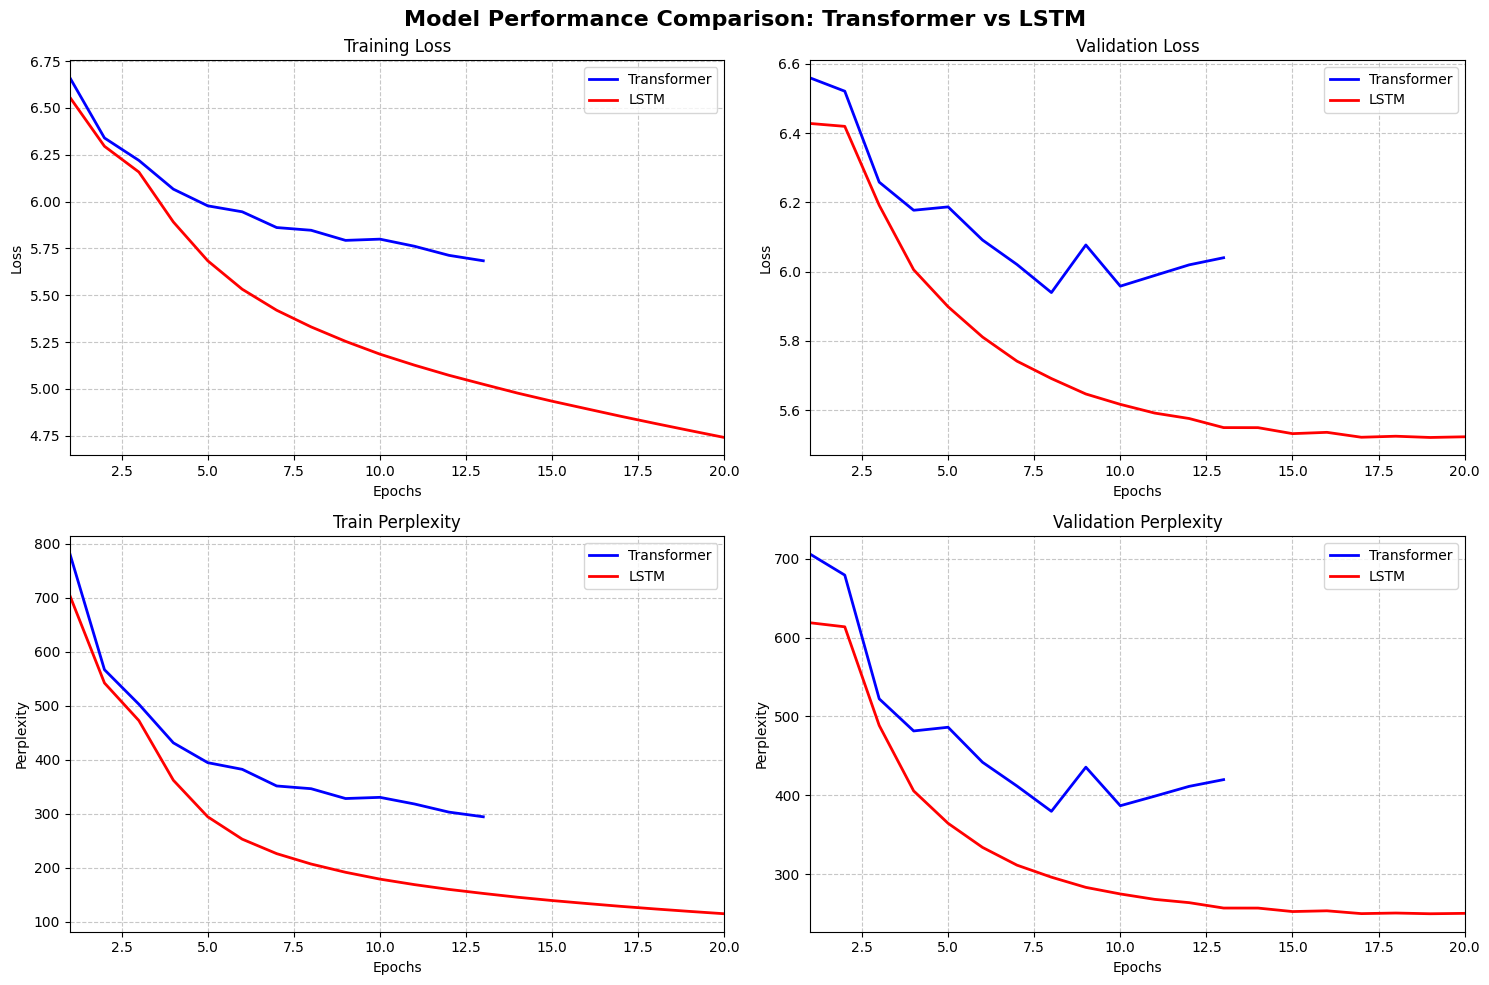

In [79]:
def plot_model_comparison(transformer_history, lstm_history):
  fig, axes= plt.subplots(2, 2, figsize= (15, 10))
  fig.suptitle("Model Performance Comparison: Transformer vs LSTM", fontsize= 16, fontweight= 'bold')

  max_epochs= max(len(transformer_history['train_losses']), len(lstm_history['train_losses']))

  transformer_epochs= range(1, len(transformer_history['train_losses']) + 1)
  lstm_epochs= range(1, len(lstm_history['train_losses']) + 1)

  ax1= axes[0,0]
  # Plot 1: Training Loss
  ax1.plot(transformer_epochs, transformer_history['train_losses'],
           'b-', label= 'Transformer', linewidth= 2)
  ax1.plot(lstm_epochs, lstm_history['train_losses'],
           'r-', label= 'LSTM', linewidth= 2)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training Loss')
  ax1.legend()
  ax1.grid(True, linestyle= '--', alpha= 0.7)
  ax1.set_xlim(1, max_epochs)

  # Plot 2: Validation Loss
  ax2= axes[0, 1]
  ax2.plot(transformer_epochs, transformer_history['val_losses'],
           'b-', label= 'Transformer', linewidth= 2)
  ax2.plot(lstm_epochs, lstm_history['val_losses'],
           'r-', label= 'LSTM', linewidth= 2)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_title('Validation Loss')
  ax2.legend()
  ax2.grid(True, linestyle= '--', alpha= 0.7)
  ax2.set_xlim(1, max_epochs)

  # Plot 3: Training Perplexity
  ax3= axes[1,0]
  ax3.plot(transformer_epochs, transformer_history['train_perplexities'],
           'b-', label= 'Transformer', linewidth= 2)
  ax3.plot(lstm_epochs, lstm_history['train_perplexities'],
           'r-', label= 'LSTM', linewidth= 2)
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('Perplexity')
  ax3.set_title('Train Perplexity')
  ax3.legend()
  ax3.grid(True, linestyle= '--', alpha= 0.7)
  ax3.set_xlim(1, max_epochs)

  # Plot 4: Validation Perplexity
  ax4= axes[1,1]
  ax4.plot(transformer_epochs, transformer_history['val_perplexities'],
           'b-', label= 'Transformer', linewidth= 2)
  ax4.plot(lstm_epochs, lstm_history['val_perplexities'],
           'r-', label= 'LSTM', linewidth= 2)
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('Perplexity')
  ax4.set_title('Validation Perplexity')
  ax4.legend()
  ax4.grid(True, linestyle= '--', alpha= 0.7)
  ax4.set_xlim(1, max_epochs)

  plt.tight_layout()
  plt.subplots_adjust(top= 0.93)
  plt.show()

plot_model_comparison(transformer_history, lstm_history)